In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGP
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
def train_test_split_random(x, Y, N_train):
    total_samples = x.shape[0]
    all_indices = np.arange(total_samples)
    
    train_indices = np.random.choice(all_indices, size=N_train, replace=False)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    x_train = x[train_indices]
    Y_train = Y[train_indices]
    x_test = x[test_indices]
    Y_test = Y[test_indices]
    
    return x_train, Y_train, x_test, Y_test

def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

def cov_to_corr(cov):
    stddev = np.sqrt(np.diag(cov))        # standard deviations
    corr = cov / np.outer(stddev, stddev) # normalize
    return corr

In [17]:
introduce_outliers = False
introduce_missing_values = True

rmses_mogp_outliers, rmses_morcgp_outliers, rmses_pm_outliers = [], [], []
nlpds_mogp_outliers, nlpds_morcgp_outliers, nlpds_pm_outliers = [], [], []

N, D = 100, 4
noise_var = 0.1
if introduce_outliers:
    epsilon = 0.1
else:
    epsilon = 0

if introduce_missing_values:
    missing_rate = 0.2
else:
    missing_rate = 0

lengthscale = 1.0
rbf_variance = 1.0

B = np.array([
    [1.0,  0.9,  0.7,  0.5],
    [0.9,  1.0,  0.8,  0.6],
    [0.7, 0.8,  1.0, 0.9],
    [0.5,  0.6,  0.9,  1.0],
])
A = np.linalg.cholesky(B)

epsilons = np.array([epsilon] * D)

for i in tqdm(range(20)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    # Add a small jitter for numerical stability
    L = cholesky(K + 1e-6*np.eye(D*N), lower=True)

    f_samples = L @ np.random.randn(D*N)
    F = f_samples.reshape(D, N).T
    Y_test = F + np.random.normal(0, noise_var, F.shape)
    Y_train = Y_test.copy()

    outliers_mask = np.zeros_like(Y_train, dtype=bool)

    # --- Step 1: Introduce missing values ---
    if introduce_missing_values:
        n_missing = int(missing_rate * Y_train.size)

        # Randomly choose flat indices for missing values
        missing_indices = np.random.choice(Y_train.size, n_missing, replace=False)

        # Convert to 2D indices
        missing_coords = np.unravel_index(missing_indices, Y_train.shape)

        # Set missing entries to NaN
        Y_train[missing_coords] = np.nan

    # --- Step 2: Introduce outliers ---
    if introduce_outliers:
        for col in range(D):
            # Indices of non-NaN values in this column
            non_nan_rows = np.where(~np.isnan(Y_train[:, col]))[0]
            n_non_nan = len(non_nan_rows)

            # Number of outliers based on non-NaN values
            num_outliers = int(epsilon * n_non_nan)

            # Randomly select outlier indices from non-NaN rows
            if num_outliers > 0:
                outlier_rows = np.random.choice(non_nan_rows, num_outliers, replace=False)

                for row in outlier_rows:
                    if np.random.rand() < 0.5:
                        Y_train[row, col] += np.random.uniform(-3, -2)  # negative outlier
                    else:
                        Y_train[row, col] += np.random.uniform(2, 3)    # positive outlier

                # Update outlier mask
                outliers_mask[outlier_rows, col] = True

        # Count outliers per column
        outliers_per_column = np.sum(outliers_mask, axis=0)
        # print("Outliers per column:", outliers_per_column)
        
    Y_train_clean = Y_train[~np.isnan(Y_train).any(axis=1)]
    mcd = MinCovDet(support_fraction=1-2*epsilon).fit(Y_train_clean)
    robust_covariance = mcd.covariance_
    robust_init_A = np.linalg.cholesky(robust_covariance)

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.1] * D), A = robust_init_A)
    mogp.fit(x, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    mu_mogp, var_mogp = mogp.predict(x)
    std_mogp = np.sqrt(var_mogp + mogp.noise)

    # MORCGP   
    morcgp = MORCGP(mean=0, length_scale=1, noise_var=np.array([0.1]*D), A=robust_init_A)
    morcgp.fit(x, Y_train, epsilons=epsilons)
    morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)
    mu_morcgp, var_morcgp = morcgp.predict(x)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

    # MORCGP (RCGP weights)
    morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=1.0, noise=np.array([0.1]*D), A=robust_init_A, epsilons=epsilons)
    morcgp_pm.fit(x, Y_train)
    morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)
    mu_pm, var_pm = morcgp_pm.predict(x)
    std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # Performance metrics
    rmse_mogp = calculate_rmse(Y_test, mu_mogp)
    rmse_pm = calculate_rmse(Y_test, mu_pm)
    rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)

    rmses_mogp_outliers.append(rmse_mogp)
    rmses_pm_outliers.append(rmse_pm)
    rmses_morcgp_outliers.append(rmse_morcgp)

    nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
    nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)
    nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)

    nlpds_mogp_outliers.append(nlpd_mogp)
    nlpds_pm_outliers.append(nlpd_pm)
    nlpds_morcgp_outliers.append(nlpd_morcgp)

print(f'RMSE MOGP: {np.mean(rmses_mogp_outliers):.4f} ± {np.std(rmses_mogp_outliers):.4f}')
print(f'RMSE MORCGP (PM): {np.mean(rmses_pm_outliers):.4f} ± {np.std(rmses_pm_outliers):.4f}')
print(f'RMSE MORCGP: {np.mean(rmses_morcgp_outliers):.4f} ± {np.std(rmses_morcgp_outliers):.4f}')

print(f'NLPD MOGP: {np.mean(nlpds_mogp_outliers):.4f} ± {np.std(nlpds_mogp_outliers):.4f}')
print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm_outliers):.4f} ± {np.std(nlpds_pm_outliers):.4f}')
print(f'NLPD MORCGP: {np.mean(nlpds_morcgp_outliers):.4f} ± {np.std(nlpds_morcgp_outliers):.4f}')

100%|██████████| 20/20 [30:25<00:00, 91.30s/it] 

RMSE MOGP: 0.0966 ± 0.0038
RMSE MORCGP (PM): 0.0966 ± 0.0046
RMSE MORCGP: 0.0960 ± 0.0038
NLPD MOGP: -0.9111 ± 0.0413
NLPD MORCGP (PM): -0.9049 ± 0.0511
NLPD MORCGP: -0.9114 ± 0.0402


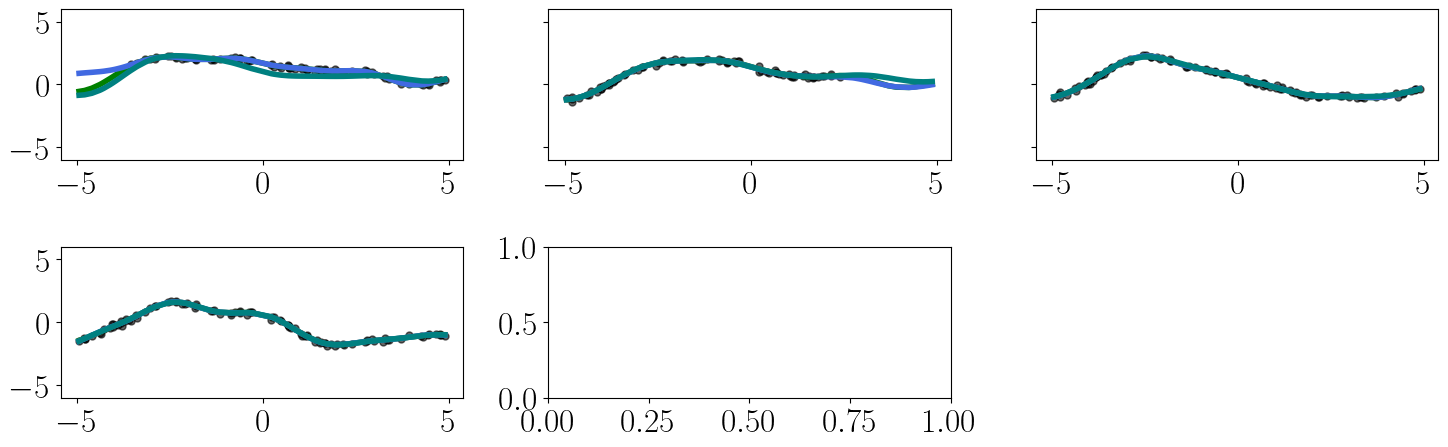

In [9]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    x_all = x.flatten()
    y_all = Y_train[:, i]

    ax.plot(x_all, y_all, 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')

    # MOGP
    ax.plot(x.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    # Predictive mean and variance
    # ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    # # RCGP
    # ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    ax.plot(x.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()